In [1]:

import pandas as pd
import numpy as np
import gdown
import os
from sklearn.model_selection import train_test_split
import random


# To improve the speed of setting up, retrieve only the files for the two groups used in training
# Swap with the line below to get the entire dataset as a zip file
# gdown.download('https://drive.google.com/uc?id=1-QTtycxsVNeym17zrMBSZCAAtEZEs05p', '/content/miniimagenet.zip', quiet=False)
gdown.download('https://drive.google.com/uc?id=1CZeMPRt4OZGJL_xQNfgi5evJW1PpA77l', '/content/miniimagenet.zip', quiet=False) # selected groups only
images_directory = '/content/miniimagenet/images/'
if not os.path.exists(images_directory):
  os.makedirs(images_directory) 
!unzip -qq /content/miniimagenet.zip -d {images_directory}


# get the CSV with the list of all file names
mini_imagenet_file_list_csv = '/content/all_imagenet_file_names.csv'
gdown.download('https://drive.google.com/uc?id=1-1JiyyEC6JlnEi0H0x-JKIGEKjdI_Nea', mini_imagenet_file_list_csv, quiet=False)
file_list = pd.read_csv(mini_imagenet_file_list_csv)

selected_groups = ['n01532829', 'n01558993']
samples_miniimagenet = file_list[file_list['label'].isin(selected_groups)].groupby('label').first()

# Other options for group pairs
# n01532829, n01558993
# n02108551, n02108915


Downloading...
From: https://drive.google.com/uc?id=1CZeMPRt4OZGJL_xQNfgi5evJW1PpA77l
To: /content/miniimagenet.zip
59.8MB [00:00, 93.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1JiyyEC6JlnEi0H0x-JKIGEKjdI_Nea
To: /content/all_imagenet_file_names.csv
2.27MB [00:00, 108MB/s]


<br>
<br>
For this analysis, the first two groups above are used n01532829 and n01558993. These are two similar-looking bird species. The goal is to train the classifier to detect minor details that distinguish the two groups.

Sample for group ID  n01532829
/content/miniimagenet/images/n0153282900000006.jpg


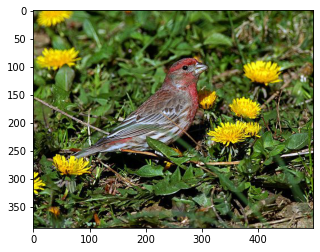

Sample for group ID  n01558993
/content/miniimagenet/images/n0155899300000838.jpg


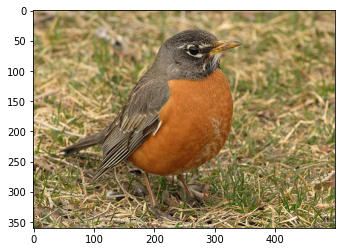

In [2]:
# show a sample from the two selected classes

from PIL import Image
from importlib import reload 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for image_path in samples_miniimagenet['filename'].unique():
    print('Sample for group ID ', image_path[:9])
    print(images_directory +  image_path)
    reload(plt)
    
    img=mpimg.imread(images_directory + image_path)
    #plt.close('all')
    imgplot = plt.imshow(img)
    plt.show()




In [3]:
# Since the imagenet files are all in the same directory, they can be used as-is 
# with the maml-pytorch setup and do not need to be processed further at this point.
# However, the directory does need to be added to the Python training file

file_list[file_list['label'].isin(selected_groups)].to_csv(images_directory + '/train.csv')

  

In [4]:
#Get the EEG spectrograms zip file and unzip it
eeg_image_directory = '/content/eeg_sz_spectrograms'
gdown.download('https://drive.google.com/uc?id=1CQwVM0OpOKAhfk6qvgbGHV8OLguYH_qJ', '{}.zip'.format(eeg_image_directory), quiet=False) 
!unzip -qq {eeg_image_directory}.zip -d {eeg_image_directory}

# rename 
dl_link = '{}/content/drive/My Drive/ML Projects/data/MSU.ru__gen_data_5s_70pct_overlap_-_fractional_noverlap_all_channels_sml_all_participants_v2/'.format(eeg_image_directory)
!mv "{dl_link}/hc" {eeg_image_directory}
!mv "{dl_link}/sz" {eeg_image_directory}


Downloading...
From: https://drive.google.com/uc?id=1CQwVM0OpOKAhfk6qvgbGHV8OLguYH_qJ
To: /content/eeg_sz_spectrograms.zip
118MB [00:00, 153MB/s] 


In [5]:
# Get the spectrograms zip file for the further step
# For this version of the program, we attempt to use spectrograms from a different EEG dataset to further train the program. The first EEG dataset will still be used for testing

further_training_image_directory = '/content/further_training_eeg_spectrograms'
gdown.download('https://drive.google.com/uc?id=1WZ1yIFE2bng0McnY_4UBJHqTttsXTTNX', '{}.zip'.format(further_training_image_directory), quiet=False) 

!unzip -qq {further_training_image_directory}.zip -d {further_training_image_directory}

# rename 
ft_dl_link = '{}/gen_data_20s_70pct_overlap_-_high_nfft_all_channels_sml/'.format(further_training_image_directory)
!mv "{ft_dl_link}/hc" {further_training_image_directory}
!mv "{ft_dl_link}/sz" {further_training_image_directory}


Downloading...
From: https://drive.google.com/uc?id=1WZ1yIFE2bng0McnY_4UBJHqTttsXTTNX
To: /content/further_training_eeg_spectrograms.zip
44.2MB [00:00, 61.6MB/s]


In [6]:
# Use EEG of Sz for validation and testing
# Extract files from an eeg_sz spectrogram directory where files are saved by subject

rand_seed = 1
# List of raw patient file IDs that should be skipped based on categorization as outliers
ignore_list = []
hc_subject_ids = ['hc' + str(i) for i in range(38) if "h{:02}".format(i) not in ignore_list] 
#There are 45 Sz participants. Select 38 of those to match with the control group
rand = random.Random(1)
sz_subject_id_range = [i for i in range(45) if "s{:02}".format(i) not in ignore_list]
sz_subject_ids = rand.sample(sz_subject_id_range, k=38) 
sz_subject_ids = ['sz' + str(i) for i in sz_subject_ids]

all_subject_ids = np.concatenate([hc_subject_ids, sz_subject_ids], axis=0)
validate_hc, test_hc = train_test_split(hc_subject_ids, test_size=0.5, random_state=rand_seed)
validate_sz, test_sz = train_test_split(sz_subject_ids, test_size=0.5, random_state=rand_seed)

validation_ids = np.concatenate([validate_hc, validate_sz])  
test_ids = np.concatenate([test_hc, test_sz]) 


print('\nSubjects assigned to groups using sklearn.model_selection.train_test_split')
print('Test group: ', ", ".join(test_ids), "\n")
print('Validation group: ', ", ".join(validation_ids), "\n")

  

from shutil import copyfile
import pandas as pd
import os 


test_images_output_directory = 'all_test_images'
validation_images_output_directory = 'all_validation_images'

if not os.path.exists(test_images_output_directory):
    os.mkdir(test_images_output_directory)
if not os.path.exists(validation_images_output_directory):
    os.mkdir(validation_images_output_directory)



# Note: CSV is only used for MAML and Prototypical networks
def gen_csv_and_copy_sz_files(image_dir, img_output_dir, participant_ids, output_name, split_with_csv=False):
    subdir_data = []
    for group in ['hc', 'sz']: #['Healthy_Control', 'Sz_Patient']:
        for pid in os.listdir(image_dir + '/' + group): # by participant IDs
            if pid in participant_ids:
              for file in os.listdir(image_dir + '/' + group + '/' + pid):
                file_data = {'filename': file, 'label': group}
                subdir_data.append(file_data)
                destination = img_output_dir + '/' + file if split_with_csv else  '{}/{}/{}'.format(img_output_dir, group, file)
                if not os.path.exists('{}/{}'.format(img_output_dir, group)):
                  os.makedirs('{}/{}'.format(img_output_dir, group))
                copyfile(image_dir + '/' + group + '/' + pid + '/' + file,  destination )
    if split_with_csv:
      pd.DataFrame(subdir_data).to_csv(img_output_dir + '/' + output_name)
    return pd.DataFrame(subdir_data)


df = gen_csv_and_copy_sz_files(image_dir=eeg_image_directory, 
                                img_output_dir=test_images_output_directory,
                                participant_ids=test_ids,
                               split_with_csv=True,
                                output_name= 'test.csv')
df = gen_csv_and_copy_sz_files(image_dir=eeg_image_directory, 
                                img_output_dir=validation_images_output_directory,
                                participant_ids=validation_ids, 
                               split_with_csv=True,
                                output_name= 'test.csv') #file must be name test.csv
print(df.head())




Subjects assigned to groups using sklearn.model_selection.train_test_split
Test group:  hc2, hc29, hc3, hc22, hc25, hc27, hc21, hc35, hc19, hc24, hc30, hc17, hc28, hc34, hc31, hc26, hc4, hc14, hc10, sz4, sz41, sz16, sz40, sz10, sz21, sz44, sz15, sz22, sz3, sz27, sz38, sz17, sz37, sz34, sz26, sz7, sz35, sz6 

Validation group:  hc33, hc23, hc32, hc20, hc18, hc6, hc13, hc7, hc36, hc1, hc16, hc0, hc15, hc5, hc11, hc9, hc8, hc12, hc37, sz20, sz18, sz29, sz14, sz0, sz28, sz43, sz30, sz23, sz36, sz33, sz8, sz19, sz31, sz39, sz13, sz24, sz1, sz11 

      filename label
0   hc33_3.png    hc
1  hc33_29.png    hc
2   hc33_6.png    hc
3  hc33_12.png    hc
4  hc33_31.png    hc


In [7]:
###########################
### Process the further training set

# Use EEG of Sz for testing
# Extract files from an eeg_sz spectrogram directory where files are saved by subject

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# List of raw patient file IDs that should be skipped based on categorization as outliers
ft_ignore_list = ['h09', 'h10', 's10', 's11', 's12']

ft_hc_subject_ids = ['hc' + str(i) for i in range(14) if "h{:02}".format(i) not in ft_ignore_list] 
ft_sz_subject_ids = ['sz' + str(i) for i in range(14) if "s{:02}".format(i) not in ft_ignore_list] 
ft_all_subject_ids = np.concatenate([ft_hc_subject_ids, ft_sz_subject_ids], axis=0)

ft_images_output_directory = '/content/all_further_training_images'

if not os.path.exists(ft_images_output_directory):
    os.mkdir(ft_images_output_directory)

print('\nAll subjects assigned to training group for further training')
print(ft_all_subject_ids)

ids = { 'test': test_ids}
  


ft_df = gen_csv_and_copy_sz_files(image_dir=further_training_image_directory, 
                                img_output_dir=ft_images_output_directory,
                                participant_ids=ft_all_subject_ids, 
                                split_with_csv = True,
                                output_name= 'train.csv')
print(ft_df.head())




All subjects assigned to training group for further training
['hc0' 'hc1' 'hc2' 'hc3' 'hc4' 'hc5' 'hc6' 'hc7' 'hc8' 'hc11' 'hc12'
 'hc13' 'sz0' 'sz1' 'sz2' 'sz3' 'sz4' 'sz5' 'sz6' 'sz7' 'sz8' 'sz9' 'sz13']
     filename label
0  hc4_54.png    hc
1  hc4_59.png    hc
2  hc4_41.png    hc
3  hc4_56.png    hc
4  hc4_23.png    hc


In [8]:
# Get the project files from github
!git clone https://github.com/MTynes/MAML-Pytorch.git maml_pytorch


Cloning into 'maml_pytorch'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 226 (delta 8), reused 7 (delta 3), pack-reused 209
Receiving objects: 100% (226/226), 672.94 KiB | 22.43 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [9]:
!python /content/maml_pytorch/train_custom_dataset.py --help


usage: train_custom_dataset.py [-h] [--train_dir TRAIN_DIR]
                               [--further_training_dir FURTHER_TRAINING_DIR]
                               [--validation_dir VALIDATION_DIR]
                               [--test_dir TEST_DIR]
                               [--run_further_training RUN_FURTHER_TRAINING]
                               [--epochs EPOCHS]
                               [--further_training_epochs FURTHER_TRAINING_EPOCHS]
                               [--n_way N_WAY] [--k_spt K_SPT] [--k_qry K_QRY]
                               [--imgsz IMGSZ] [--imgc IMGC]
                               [--task_num TASK_NUM] [--meta_lr META_LR]
                               [--update_lr UPDATE_LR]
                               [--update_step UPDATE_STEP]
                               [--update_step_test UPDATE_STEP_TEST]
                               [--accuracy_log_file ACCURACY_LOG_FILE]

optional arguments:
  -h, --help            show this help message a

In [10]:
# run the training file

import timeit

start = timeit.default_timer()

n_epochs = 200 * 10000 # must be multiple of 10000
ft_n_epochs = 200 * 10000
!python /content/maml_pytorch/train_custom_dataset.py --run_further_training 'true' --epochs {n_epochs} --further_training_epochs {ft_n_epochs}


stop = timeit.default_timer()
print('MAML execution time: {} hrs'.format((stop - start)/60/60) )



Namespace(accuracy_log_file='/content/mean_test_accuracy.txt', epochs=2000000, further_training_dir='/content/all_further_training_images', further_training_epochs=2000000, imgc=3, imgsz=84, k_qry=5, k_spt=1, meta_lr=0.001, n_way=2, run_further_training=True, task_num=4, test_dir='/content/all_test_images', train_dir='/content/miniimagenet/images', update_lr=0.01, update_step=5, update_step_test=10, validation_dir='/content/all_validation_images')
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
Meta(
  (net): Learner(
    conv2d:(ch_in:3, ch_out:32, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(32,)
    max_pool2d:(k:2, stride:2, padding:0)
    conv2d:(ch_in:32, ch_out:32, k:3x3, stride:1, padding:0)
    relu:(True,)
    bn:(32,)
    max_pool2d:(k:2, stride:2, padding:0)
    conv2d:(ch_in:32, ch_out:32, k:3x3, strid

Mean Test Accuracy over Epochs


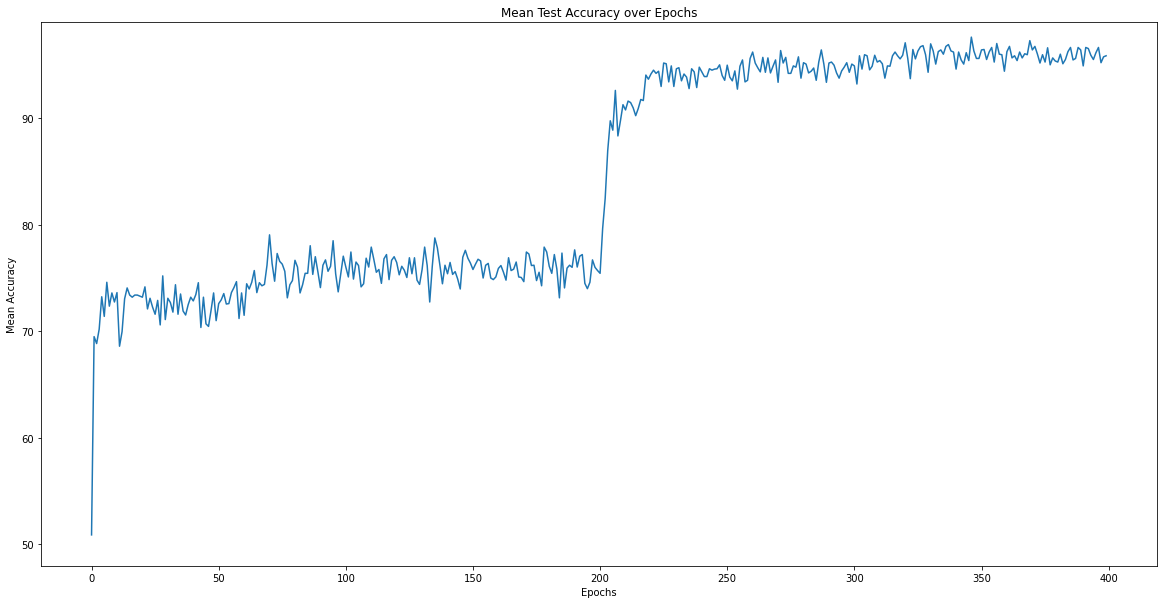

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))


print('Mean Test Accuracy over Epochs')

text_file = open('/content/mean_test_accuracy.txt', "r")
mean_accs = text_file.read().split('\n')
mean_accs = [(float(ma) * 100) for ma in mean_accs]

axes = plt.gca()
axes.set_ylim([np.int(min(mean_accs)-2), np.int(max(mean_accs)) +2])
        
plt.plot(mean_accs)
plt.xlabel('Epochs')
plt.ylabel('Mean Accuracy')
plt.title('Mean Test Accuracy over Epochs')
plt.show();

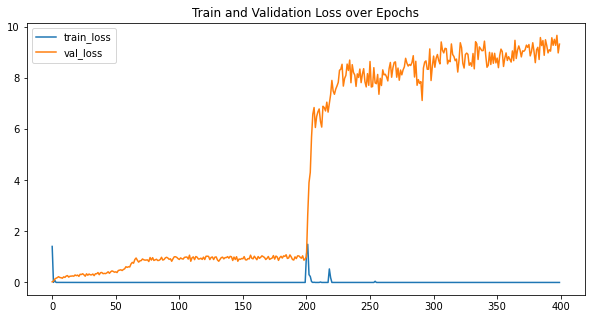

In [12]:
metrics = pd.read_csv('mean_metrics.csv')
metrics.head()

metrics[['train_loss', 'val_loss']].plot(figsize=(10,5), title='Train and Validation Loss over Epochs')

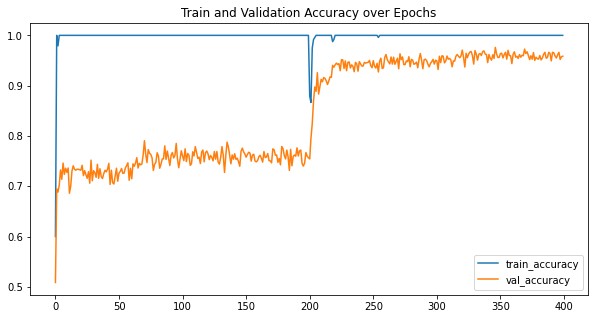

In [13]:
metrics[['train_accuracy', 'val_accuracy']].plot(figsize=(10,5), title='Train and Validation Accuracy over Epochs')

In [14]:
import matplotlib.pyplot as plt
import itertools

# modified from main.py https://github.com/zhangrong1722/CheXNet-Pytorch

def plt_roc(test_y, probas_y, plot_micro=False, plot_macro=False):
    assert isinstance(test_y, list) and isinstance(probas_y, list), 'the type of input must be list'
    skplt.metrics.plot_roc(test_y, probas_y, plot_micro=plot_micro, plot_macro=plot_macro)
    plt.savefig('roc_auc_curve.png')
    plt.show()
    plt.close()


###########################################
# Define confusion matrix and ROC visualization functions
# from https://colab.research.google.com/drive/1ISfhxFDntfOos7cOeT7swduSqzLEqyFn#scrollTo=UiKRYOWPfhJs

def plot_confusion_matrix(cm, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          cv=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if classes:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.locator_params(nbins=2)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [15]:
pred_df = pd.read_csv('test_predictions_and_labels.csv')

In [16]:
from IPython.display import display

# Get the predicted labels for metric calculations.
#
# Since prototypical networks always sets the ground truth to 0,
# infer the predicted class label from true label and the Boolean value for 'correct'
# To do this, set hc to be -1 and sz to 1. This allows the opposite class to be selected
# for rows where correct is False by multiplying the true_label by -1
pred_df['true_label'] = pred_df.apply(lambda x: -1 if x['true_label'] == 0 else 1, axis=1)
pred_df['correct'] = pred_df.apply(lambda x: 1 if x['correct'] == True else 0, axis=1)
pred_df['prediction'] = pred_df.apply(lambda x: x['true_label']
  if x['correct'] == 1 else x['true_label'] * -1, axis=1)
pred_df.replace(-1, 0, inplace=True)
# display(pred_df.head())
# pred_df.tail()



Confusion matrix, without normalization


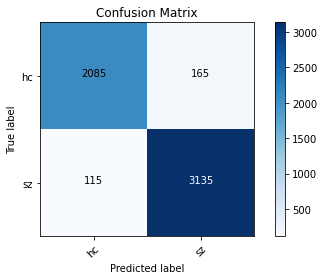

In [17]:
from sklearn.metrics import confusion_matrix


pred_y = pred_df['prediction'].values
truth_y = pred_df['true_label'].values
#probas_y = [s.replace('[', '').replace(']', '').split(', ') for s in best_model_preds['probas_y'].values]
#probas_y = [[float(t[0]), float(t[1])] for t in probas_y]


confusion = confusion_matrix(pred_y, truth_y)
plot_confusion_matrix(confusion,
                      classes=['hc', 'sz'],
                      title='Confusion Matrix')

In [18]:
pd.read_csv('metrics_summary.csv')

,Final Val Support Loss,Final Val Query Loss,Final Val Accuracy,Test Support Loss,Test Query Loss,Test Accuracy,Test AUC,Test F1 Score Macro,Test F1 Score Micro
0,9.336,0.2017,0.9585,8.587248,0.196145,0.949091,0.948864,0.947165,0.949091
